In [1]:
%config InlineBackend.figure_format = 'retina'
import torch
import pickle
import graph_generation
import numpy as np

In [2]:
graphs, metadata = graph_generation.community_sbm.load_community_dataset("data/community_sbm/params_2_30_0.8_0.02_8/graphs.pkl")

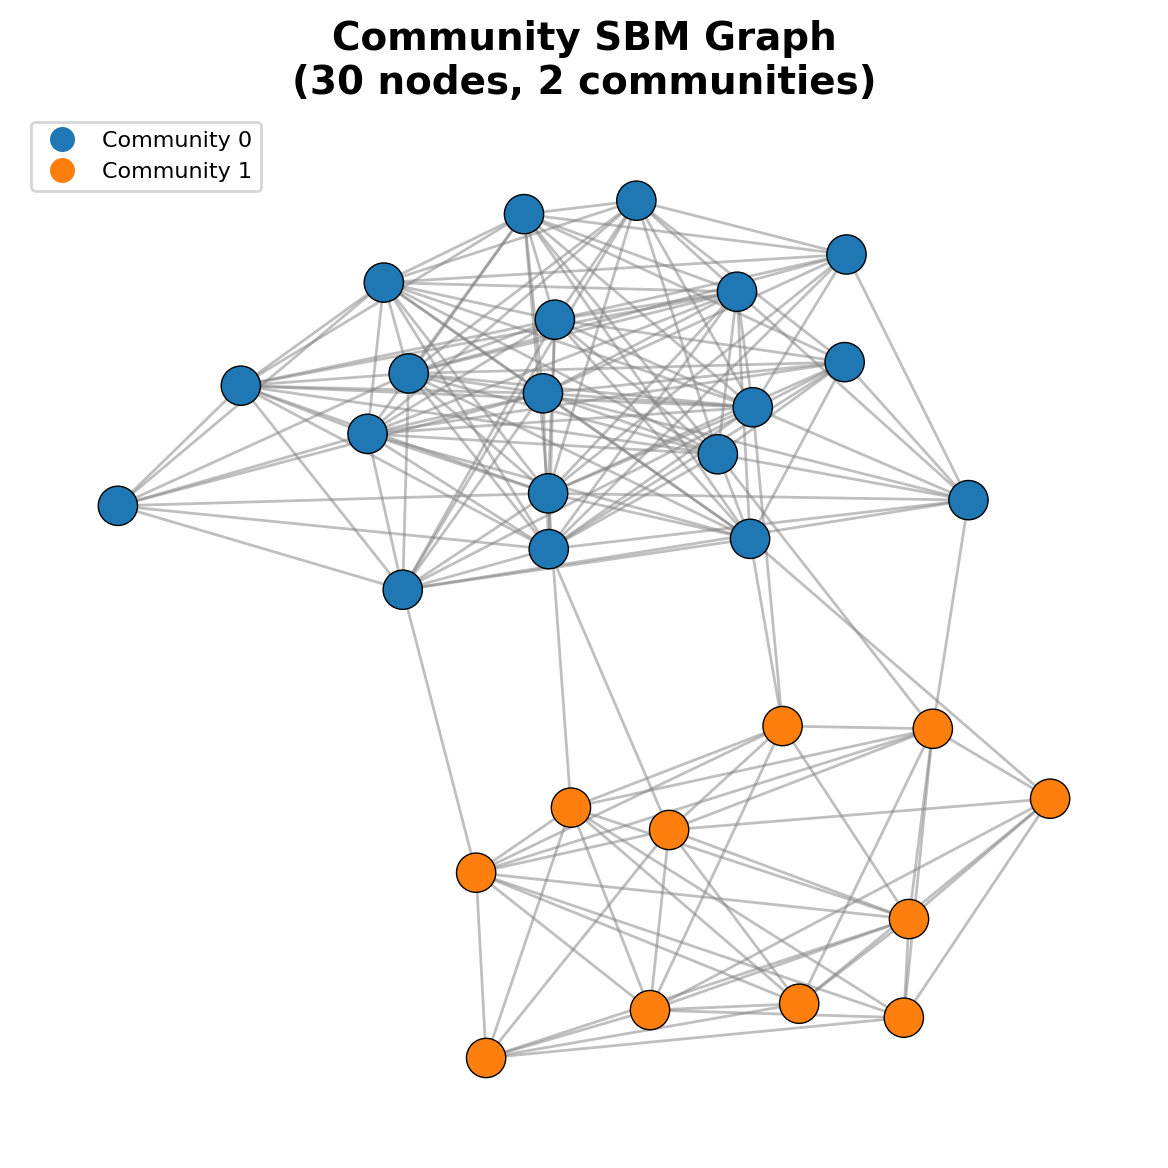

In [3]:
_ = graph_generation.visualization.show_community_graph(graphs[0])

In [4]:
import os
import time
import pickle
import numpy as np
import torch
from tqdm import tqdm

from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.samplers import MHSamplerFeatures, GraphTuple, ChimeraSamplerFeatures

def basic_observables(graph_tuple: GraphTuple) -> torch.Tensor:

    mtx = graph_tuple.adj
    feat = graph_tuple.node_features

    nn = torch.sum(feat,axis=0)
    mm = (feat.T) @ mtx @ feat
    #val = 10 * mm[0,0]/torch.sum(feat, axis = 0)[0]
    mm = mm / nn
    mm = mm.ravel()
    edges = torch.sum(mtx) / 2
    triangles = torch.trace(mtx @ mtx @ mtx) / 6
    #return torch.stack([mm[0], mm[1], mm[2], mm[3], edges, triangles])
    return torch.stack([nn[0], nn[1], mm[0]* mm[3], -mm[1] * mm[2], edges, triangles])

class MySampler(MHSamplerFeatures):
#class MySampler(ChimeraSamplerFeatures):
    def __init__(self, p_edge = 0.8, backend = "cpu"):
        super().__init__(p_edge = p_edge, backend = backend)
    def observables(self, graph_tuple): 
        return basic_observables(graph_tuple)


In [5]:
basic_observables(graphs[0])

tensor([ 1.9000e+01,  1.1000e+01,  1.0122e+02, -3.0622e-01,  1.7400e+02,
         4.4500e+02])

In [6]:

sampler = MySampler()

In [7]:

graph = graphs[0]
obs   = sampler.observables(graph)
params = torch.Tensor([0., 0., 0., 0., 0., 0.])
niter  = 500000
params_update_every = 5
save_every = 250
alpha = 0.0002
min_change = 0.001
tot_accept = 1000000

params_hist, graph_hist = sampler.param_run(
    graph=graph,
    observables=obs,
    params=params,
    niter=niter,
    params_update_every=params_update_every,
    save_every=save_every,
    save_params=True,
    alpha=alpha,
    min_change=min_change,
    tot_accept=tot_accept,
    verbose_level=0
)

params_final = params_hist[-1]
print(params_final)

new_graph = graph.clone()
new_graph.node_features = torch.zeros_like(new_graph.node_features)

return_obs, return_graph = sampler.sample_run(
    graph=graph,
    params=params_final,
    niter=100000,
    save_every=save_every,
    burn_in=0.3
)

final_params = params_hist[-1]

# sampler.param_run already prints accepted/rejected
# but we try to extract them from attributes if present
accepted = getattr(sampler, "accepted_steps", None)
rejected = getattr(sampler, "rejected_samples", None)
acc_rate = (accepted / niter) if accepted is not None else None


100%|██████████| 500000/500000 [02:43<00:00, 3057.85it/s]


number of accepted steps is:  293576
number of rejected samples:  206424
number of effective updates is:  58715
tensor([ 9.0468e-03, -9.0468e-03,  1.7517e+00,  2.6891e+01, -9.5925e-01,
         5.1412e-03])


100%|██████████| 100000/100000 [00:26<00:00, 3813.39it/s]

number of accepted steps is:  23012
number of rejected samples:  76988
Mean obs:  tensor([ 1.9000e+01,  1.1000e+01,  1.2105e+02, -3.7950e-01,  1.8154e+02,
         4.8371e+02])


<Figure size 640x480 with 0 Axes>

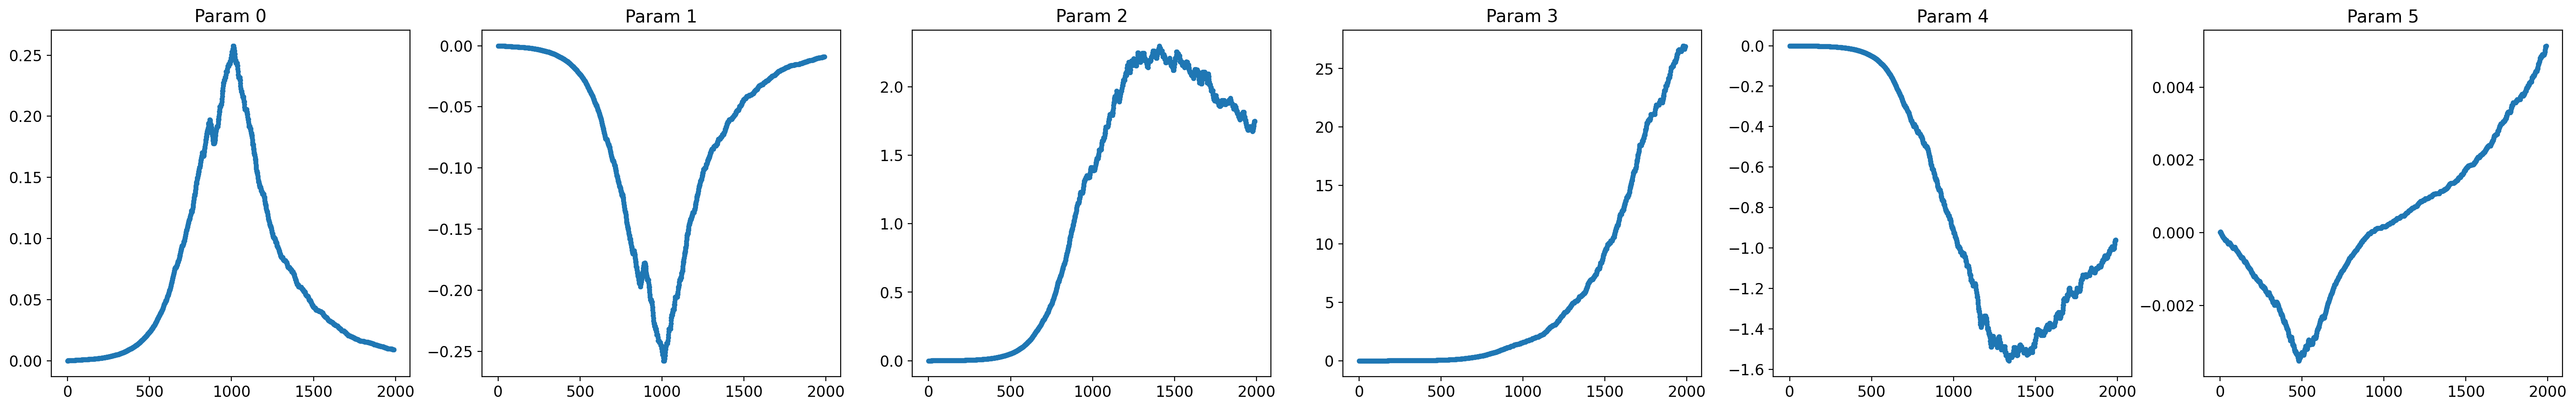

In [8]:

import matplotlib.pyplot as plt

pp = torch.stack(params_hist).numpy()
n_params = pp.shape[1]
height = 5
width = 6
plt.tight_layout()
plt.figure(figsize = (width * n_params, height))

for i in range(n_params):
    plt.subplot(1,n_params, i + 1)
    plt.title(f"Param {i}")
    plt.plot(pp[:,i], ".-")


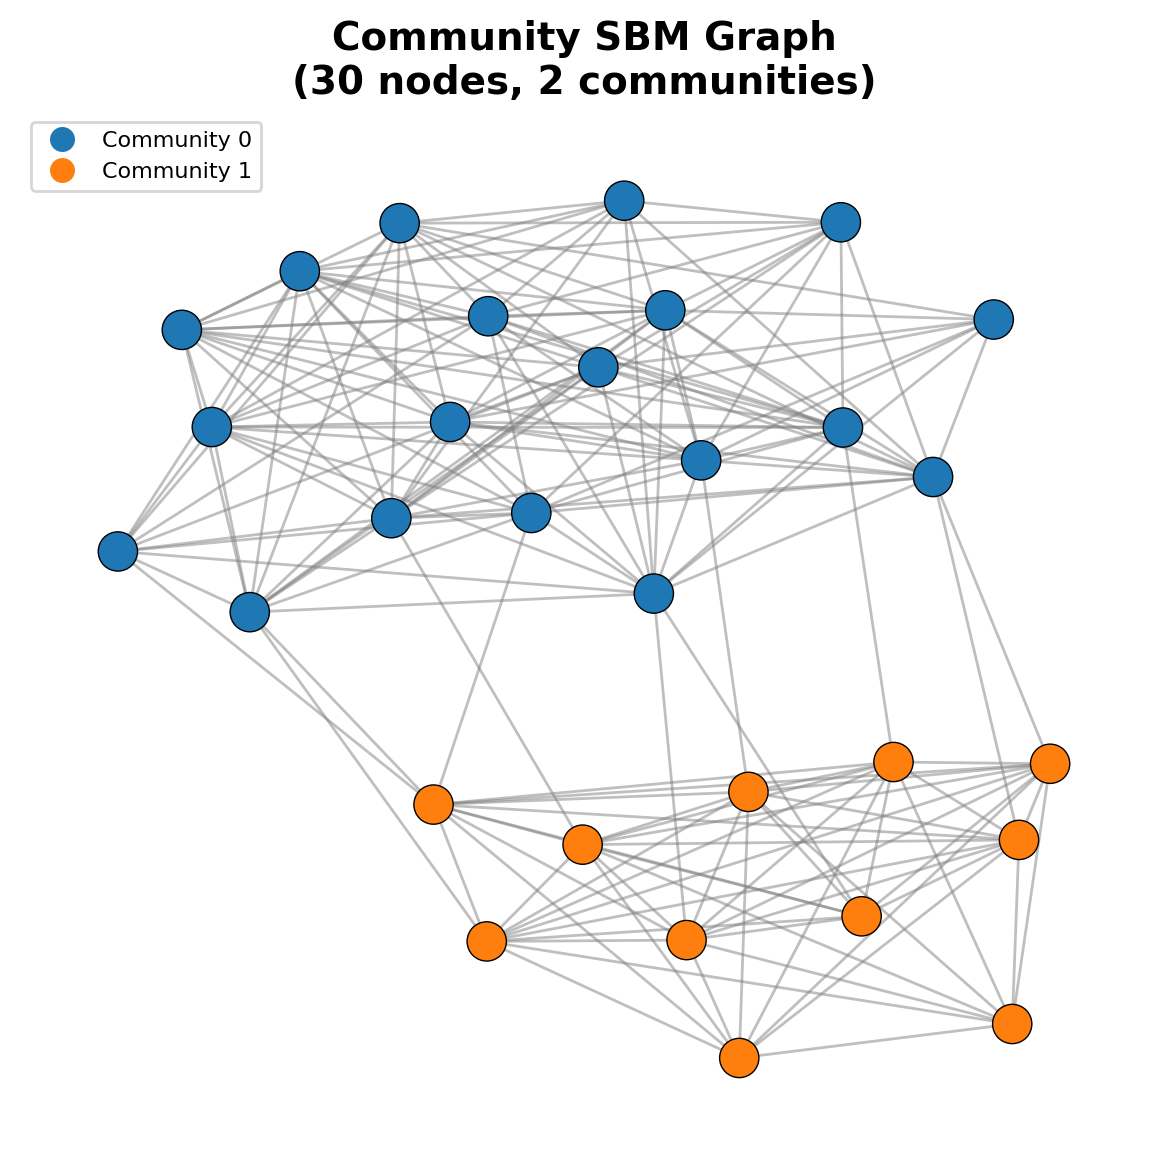

In [9]:
_ = graph_generation.visualization.show_community_graph(return_graph[-1])

In [9]:
class MySampler2(MHSamplerFeatures):
    def __init__(self, p_edge = 0.8, backend = "cpu"):
        super().__init__(p_edge = p_edge, backend = backend)
    def observables(self, graph_tuple): 
        return basic_observables(graph_tuple)

In [10]:
sampler = MySampler2()
graph = graphs[0]
obs   = sampler.observables(graph)
params = torch.Tensor([0., 0., 0., 0., 0., 0.])
niter  = 500000
params_update_every = 5
save_every = 250
alpha = 0.0002
min_change = 0.001
tot_accept = 1000000

params_hist, graph_hist = sampler.param_run(
    graph=graph,
    observables=obs,
    params=params,
    niter=niter,
    params_update_every=params_update_every,
    save_every=save_every,
    save_params=True,
    alpha=alpha,
    min_change=min_change,
    tot_accept=tot_accept,
    verbose_level=0
)

params_final = params_hist[-1]
print(params_final)

return_obs, return_graph = sampler.sample_run(
    graph=graph,
    params=params_final,
    niter=100000,
    save_every=save_every,
    burn_in=0.3
)

final_params = params_hist[-1]

# sampler.param_run already prints accepted/rejected
# but we try to extract them from attributes if present
accepted = getattr(sampler, "accepted_steps", None)
rejected = getattr(sampler, "rejected_samples", None)
acc_rate = (accepted / niter) if accepted is not None else None



100%|██████████| 500000/500000 [02:49<00:00, 2951.61it/s]


number of accepted steps is:  284452
number of rejected samples:  215548
number of effective updates is:  56890
tensor([ 3.2204e+00, -3.2204e+00,  1.1735e+00,  2.7705e+01, -6.1191e-01,
         4.2680e-03])


100%|██████████| 100000/100000 [00:29<00:00, 3356.65it/s]

number of accepted steps is:  35803
number of rejected samples:  64197
Mean obs:  tensor([ 20.7415,   9.2585,  80.8834,  -0.3697, 156.4796, 289.7007])


<Figure size 640x480 with 0 Axes>

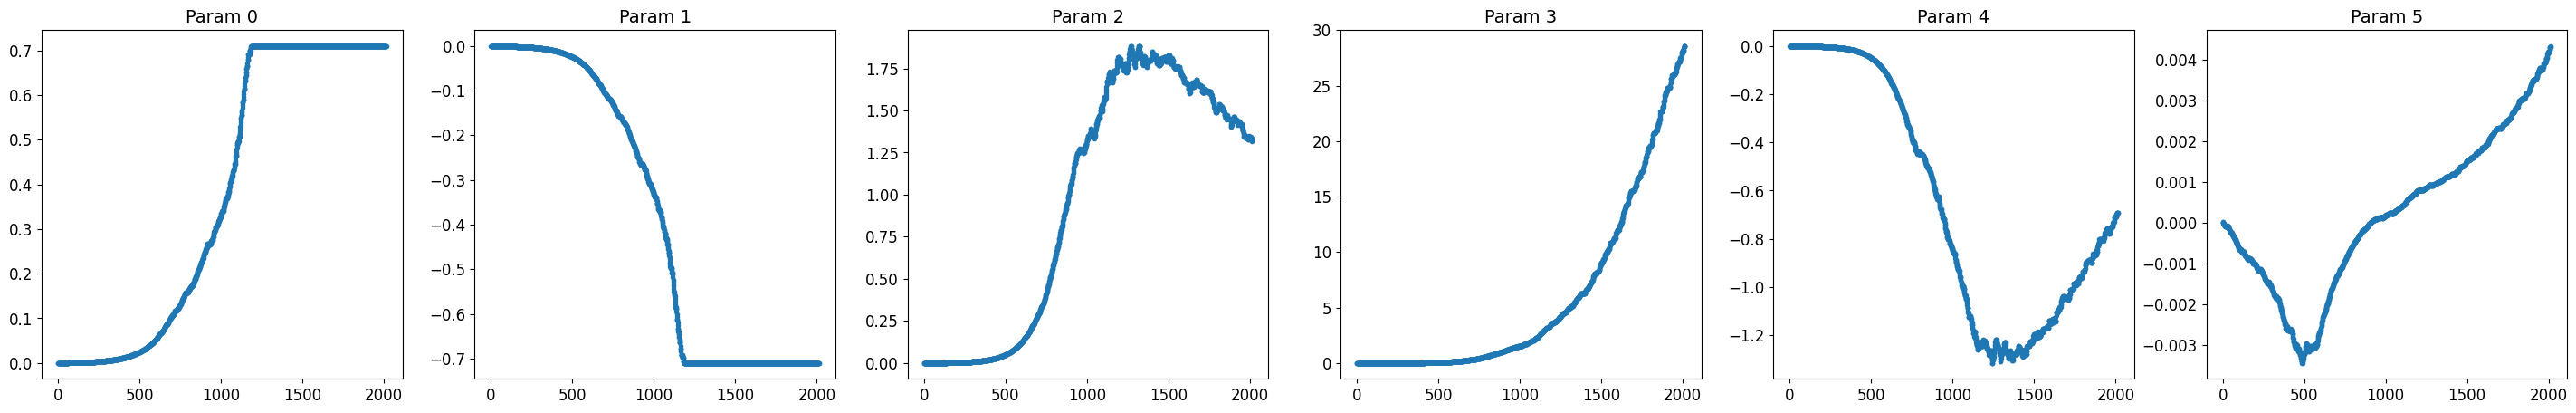

In [26]:
import matplotlib.pyplot as plt

pp = torch.stack(params_hist).numpy()
n_params = pp.shape[1]
height = 5
width = 6
plt.tight_layout()
plt.figure(figsize = (width * n_params, height))

for i in range(n_params):
    plt.subplot(1,n_params, i + 1)
    plt.title(f"Param {i}")
    plt.plot(pp[:,i], ".-")

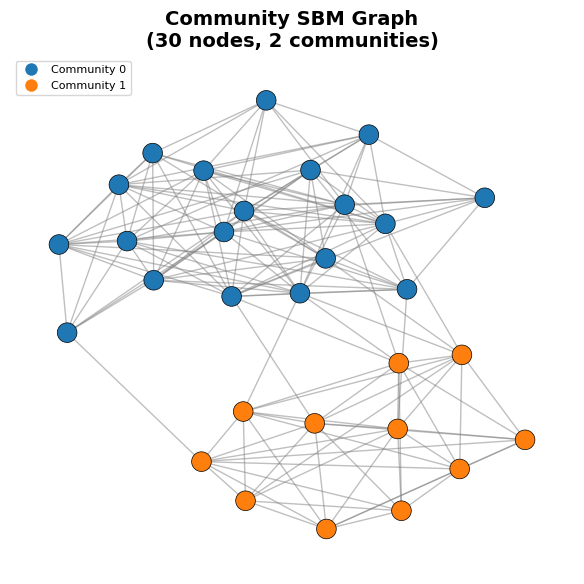

In [27]:
_ = graph_generation.visualization.show_community_graph(return_graph[-1])